In [15]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

iwa = 2.8
owa = 9.7

# Load PSFs

In [2]:
psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20220920.fits'

psfs = fits.getdata(psfs_fpath)
print(psfs.shape, len(psfs))

(985, 64, 64) 985


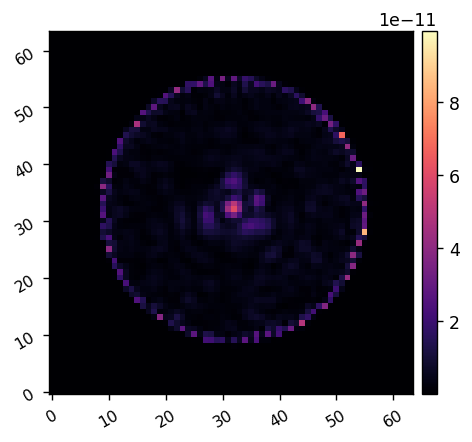

In [4]:
misc.myimshow(psfs[0], lognorm=False)

In [30]:
for i,psf in enumerate(psfs):
    misc.myimshow(psf, lognorm=True)
    time.sleep(0.5)
    clear_output(wait=True)

KeyboardInterrupt: 

In [6]:
r_offsets

array([ 0.        ,  0.20721561,  0.41443121,  0.62164682,  0.82886243,
        1.03607803,  1.24329364,  1.45050925,  1.65772485,  1.86494046,
        2.07215607,  2.27937167,  2.48658728,  2.69380289,  2.90101849,
        3.1082341 ,  3.31544971,  3.52266531,  3.72988092,  3.8       ,
        4.21443121,  4.62886243,  5.04329364,  5.45772485,  5.87215607,
        6.28658728,  6.70101849,  7.11544971,  7.52988092,  7.94431213,
        8.35874335,  8.77317456,  9.18760577,  9.60203699,  9.7       ,
       10.52886243, 11.35772485, 12.18658728, 13.01544971, 13.84431213,
       14.67317456, 15.50203699])

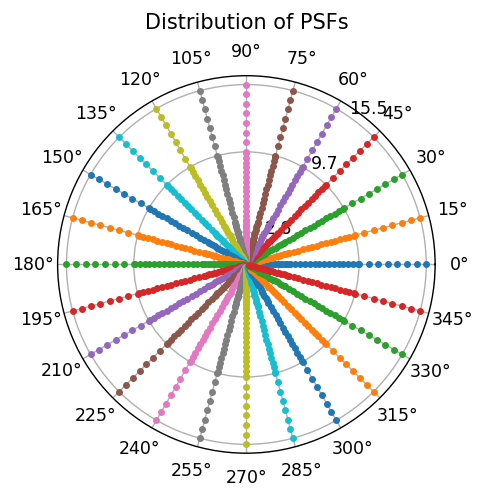

In [5]:
r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20220920.fits'
thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20220920.fits'

r_offsets = fits.getdata(r_offsets_fpath)
thetas = fits.getdata(thetas_fpath)*u.degree

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=125)
ax.plot(theta_offsets, r_offsets[1:], '.')
ax.set_rticks([iwa, owa, max(r_offsets)])  # Less radial ticks
ax.set_thetagrids(thetas.value)
ax.set_rlabel_position(55)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title('Distribution of PSFs', va='bottom')
plt.show()

# Setup/Test the interpolating function

In [7]:
r_offsets_mas = r_offsets * mas_per_lamD

# def find_closest_psf(xoff, yoff, verbose=True):
#     r = np.sqrt(xoff**2+yoff**2)
#     theta = np.arctan2(yoff,xoff).to(u.deg)
#     if theta<0: theta += 360*u.deg
        
#     kr = np.argmin(np.abs(r_offsets_mas-r))
#     if kr>(len(r_offsets)-1):
#         kr = len(r_offsets)-1
#     kth = np.argmin(np.abs(thetas-theta))
#     theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
#     if kr==0: 
#         kpsf=0
#     else: 
#         kpsf = 1 + kth + (len(thetas))*(kr-1)
    
#     if verbose: 
#         print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
#         print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
#         print('PSF index = {:d}'.format(kpsf))
    
#     closest_psf = psfs[kpsf]
#     interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=5)
    
#     return interpped_psf

def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=0)
    
    return interpped_psf

Desired r=200.00 mas, radial index=19, closest available r=190.72 mas
Desired th=20.00 deg, theta index=1, closest available th=15.00 deg, difference=5.00 deg
PSF index = 434


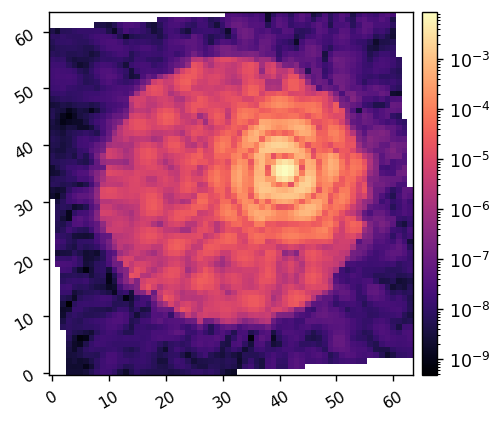

In [11]:
r = 200*u.mas
th = 20*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

# Create the grid for which the interpolated PSFs will be calculated

In [12]:
ndisk = 128
disk_pixelscale_mas = 10.5*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-666.75, -656.25, -645.75, ...,  645.75,  656.25,  666.75] mas>

Desired r=942.93 mas, radial index=41, closest available r=778.04 mas
Desired th=225.00 deg, theta index=15, closest available th=225.00 deg, difference=0.00 deg
PSF index = 976


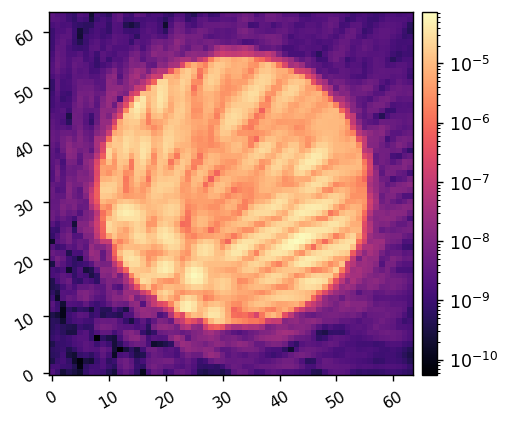

In [13]:
xoff = x[0]
yoff = y[0]
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

In [16]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

16383 17.90154242515564


In [17]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20220920.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()